---
## ODF Classifier with BioBERT  
---
### Content
---

- **[Libraries to use](#Libraries_to_use)**

- **[Loading the dataset](#Loading_dataset)**

- **[Cleaning the dataset and extracting required features](#Cleaning_extracting)**

- **[Including reversed findings to the dataset](#Reversed_findings)**

- **[Creating a dictionary with train, test, validation datasets](#train_test_validation)**

- **[Load tokenizer and model](#tokenizer_model)**

- **[Tokenize the datasets](#tokenize)**

- **[Formating to torch](#Formating)**

- **[Extracting hidden states](#Extracting_hidden_states)**

- **[Creating a feature matrix](#feature_matrix)**

- **[Visualizing the training set](#Visualizing_training)**

- **[Training a classifier](#Training_classifier)**

 ---

---
### Libraries to use <a id="Libraries_to_use"> </a>
---

In [1]:
#------------------------------------------------------
# Regular modules
#------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
#------------------------------------------------------
# To avoid warnings
#------------------------------------------------------
import os
import warnings 
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#------------------------------------------------------
# Not regular modules
#------------------------------------------------------
import datasets
import torch
from umap import UMAP
from transformers import AutoTokenizer, AutoModel
#------------------------------------------------------
# Created modules
#------------------------------------------------------
from Classifier import data_cleaning  
from Classifier import including_reversing 
from Classifier import train_test_validation  

---
### Loading the dataset <a id="Loading_dataset"> </a>
---

In [2]:
fake = pd.read_csv("../data/fake.csv")

In [3]:
fake=fake.rename(columns={"out":"text"})

In [4]:
fake.head()

,Unnamed: 0,text,NA
0,out1,"Hospital Number: R1265623 , Hospital: Random N...",\nNA
1,out2,"Hospital Number: K2515095 , Hospital: Random N...",Nature of specimen:x9 stomach biopsy specimens...
2,out3,"Hospital Number: L7746099 , Hospital: Random N...",\ncharacter(0)
3,out4,"Hospital Number: J4131371 , Hospital: Random N...",
4,out5,"Hospital Number: S4637507 , Hospital: Random N...",Nature of specimen:x6 fundus biopsy specimens ...


---
### Cleaning the dataset and extracting required features <a id="Cleaning_extracting"> </a>
---

In [5]:
fakedf = data_cleaning(fake)

In [6]:
fakedf.shape

(50000, 3)

---
### Including reversed findings to the dataset <a id="Reversed_findings"> </a>
---

In [7]:
#-----------------------------------------------------
real = pd.read_csv('../data/real.csv') 
real=real.rename(columns={"out":"text"})
realdf = data_cleaning(real)
realfindings = realdf[['findings']]
realfindings['label'] = 1
# # #-----------------------------------------------------
fakefindings = fakedf[['findings']]
fakefindings['label'] = 0
sentences = pd.concat([fakefindings, realfindings])
# #-----------------------------------------------------

In [8]:
sentences

,findings,label
0,Columnar lined oesophagus is present. The segm...,0
1,There is an ulcer in the stomach which is supe...,0
2,LA Grade D oesophagitis. The oesopahgitis is ...,0
3,There is a polyp in the body which is sessile ...,0
4,There is a stricture in the fundus which is Oe...,0
...,...,...
49995,There is a polyp in the oesophagus at 22 cm wh...,1
49996,There is a nodule in the oesophagus at 39 cm w...,1
49997,Normal gastroscopy to the duodenum.,1
49998,Normal gastroscopy to the duodenum.,1


In [9]:
# sentences.tail(3)

---
### Creating a dictionary with train, test, validation datasets <a id="train_test_validation"> </a>
---

In [10]:
Dict_datasets = train_test_validation(sentences)

In [11]:
Dict_datasets

DatasetDict({
    train: Dataset({
        features: ['findings', 'label'],
        num_rows: 49000
    })
    test: Dataset({
        features: ['findings', 'label'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['findings', 'label'],
        num_rows: 21000
    })
})

---
### Load tokenizer and model <a id="tokenizer_model"> </a>
---

- BioBERT is a pre-trained language model that is designed for biomedical natural language processing (NLP) tasks. It is based on the Google's BERT (Bidirectional Encoder Representations from Transformers) architecture.

- BioBERT is pre-trained on a large corpus of biomedical text data, which includes abstracts and full-text articles from PubMed Central and other biomedical databases. 

---

In [12]:
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")

In [13]:
model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1", num_labels=2)

---
### Tokenize the datasets <a id="tokenize"> </a>
---

In [14]:
#--------------------------------------------------------------------
# define function to tokenize the datasets
#--------------------------------------------------------------------
def tokenize(data):
    return tokenizer(data["findings"], padding=True, truncation=True,max_length=5) 
#--------------------------------------------------------------------
# tokenize datasets
#--------------------------------------------------------------------
Dict_datasets_encoded = Dict_datasets.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/49000 [00:00<?, ? examples/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/21000 [00:00<?, ? examples/s]

---
### Formating to torch <a id="Formating"> </a>
---

In [15]:
Dict_datasets_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

---
### Extracting hidden states <a id="Extracting_hidden_states"> </a>
---

How will extract the hidden states associated with each finding.

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}
dataset_hidden = Dict_datasets_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/49000 [00:00<?, ? examples/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/21000 [00:00<?, ? examples/s]

---
### Creating a feature matrix <a id="feature_matrix"> </a>
---

We will use the hidden states as input features and the labels as targets.

In [17]:
X_train = np.array(dataset_hidden["train"]["hidden_state"])
X_valid = np.array(dataset_hidden["validation"]["hidden_state"])
X_test = np.array(dataset_hidden["test"]["hidden_state"])
y_train = np.array(dataset_hidden["train"]["label"])
y_valid = np.array(dataset_hidden["validation"]["label"])
y_test = np.array(dataset_hidden["test"]["label"])
X_train.shape, X_valid.shape, X_test.shape

((49000, 768), (21000, 768), (30000, 768))

In [18]:
feature_matrix_list = [X_train,X_valid,X_test,y_train,y_valid,y_test]

In [22]:
np.save('feature_matrix_list.npy', np.array(feature_matrix_list, dtype=object), allow_pickle=True)

In [23]:
feature_matrix_list_loaded = np.load('feature_matrix_list.npy', allow_pickle=True)
[X_train,X_valid,X_test,y_train,y_valid,y_test]=feature_matrix_list_loaded

---
### Visualizing the training set <a id="Visualizing_training"> </a>
---

In [25]:
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,-8.972424,-3.131329,0
1,12.706798,10.200163,0
2,4.185902,-12.609386,1
3,4.834349,-0.968778,1
4,17.052862,1.450678,1


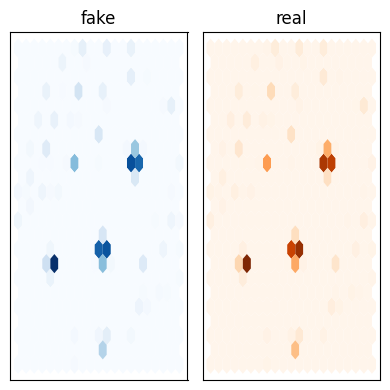

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(4,4))
axes = axes.flatten()
cmaps = ["Blues", "Oranges"]
labels = ['fake','real']

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

---
### Training a classifier <a id="Training_classifier"> </a>
---

In [27]:
lr_clf = LogisticRegression(max_iter=100)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.49857142857142855

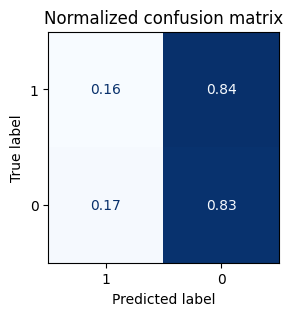

In [28]:
y_preds = lr_clf.predict(X_test)

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(3, 3))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(y_preds, y_test, [1,0])